# DDPM - I want to ride my bicycle!

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torch import nn
from tqdm.notebook import trange, tqdm

from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Metrics

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: kukubaczek (qqb). Use `wandb login --relogin` to force relogin


True

## Importing the data

In [3]:
BICYCLE_PATH = 'bicycle.txt'

In [4]:
bicycle = np.loadtxt(BICYCLE_PATH)
bicycle = torch.from_numpy(bicycle).to(torch.float32)

class CustomDataset(Dataset):
    def __init__(self, txt_file):
        loaded_array = np.loadtxt(BICYCLE_PATH)
        self.data = torch.from_numpy(loaded_array).to(torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
dataset = CustomDataset(BICYCLE_PATH)
dataloader = DataLoader(dataset, batch_size=64)

In [5]:
def scatter(bicycle, title='', ax=plt):
    ax.axis(xmin=-1, xmax=1, ymin=-1, ymax=1)
    return ax.scatter(bicycle[:,0], bicycle[:,1], s=0.1)

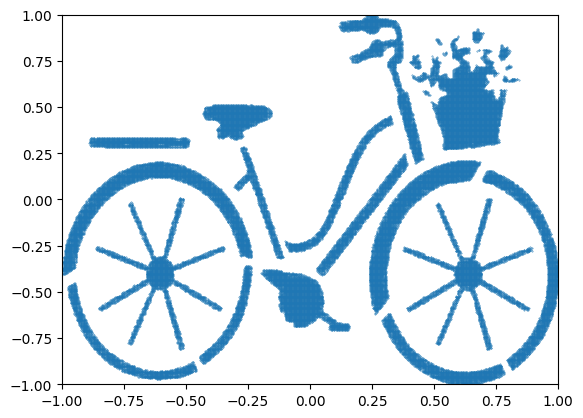

In [6]:
scatter(bicycle)

## Forward diffusion

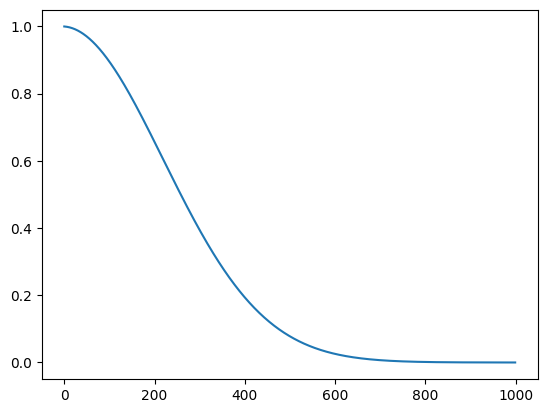

In [7]:
class DiffusionModel():
    def __init__(self, T=1000, beta_min=0.0001, beta_max=0.02):
        self.betas = torch.linspace(beta_min, beta_max, steps=T).to(device)
        self.alphas = (1.0 - self.betas).to(device)
        self.alphas_ = torch.cumprod(self.alphas, axis=0).to(device)
        
    # x0 - (N, 2)
    # t - (N)
    def q_sample(self, x0, t):
        N = x0.size(0)
        
        # take alphas_ at indices of t
        alphas_t = torch.take(self.alphas_.cpu(), t).cpu()
        
        loc = torch.sqrt(alphas_t).unsqueeze(-1) * x0
        scale_1d = (1 - alphas_t) * torch.ones(N, device=x0.device)
        scale = scale_1d.unsqueeze(-1).expand(-1, x0.size(1))

        result = torch.normal(mean=loc, std=scale)

        return result
    
    def q_sample2(self, points, t, noise):
        N = points.size(0)
        
        # take alphas_ at indices of t
        alphas_t = torch.take(self.alphas_, t)
        
        result = torch.sqrt(alphas_t).unsqueeze(-1) * points
        alphas_t_2 = alphas_t.repeat(2, 1).T
        result += torch.sqrt(1 - alphas_t_2) * noise

        return result


        
diffusion = DiffusionModel()
plt.plot(diffusion.alphas_.cpu())

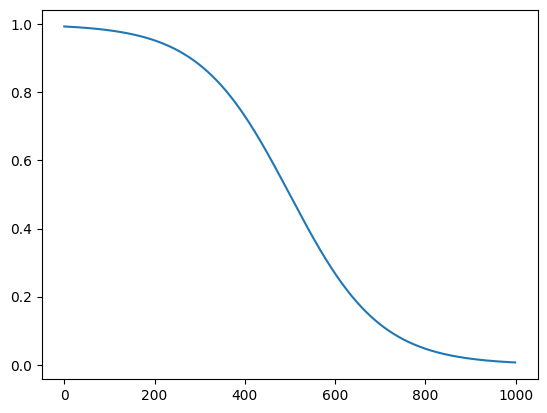

In [8]:
alphas2_ = torch.sigmoid(torch.linspace(5, -5, 1000))
plt.plot(torch.arange(0, 1000), alphas2_)

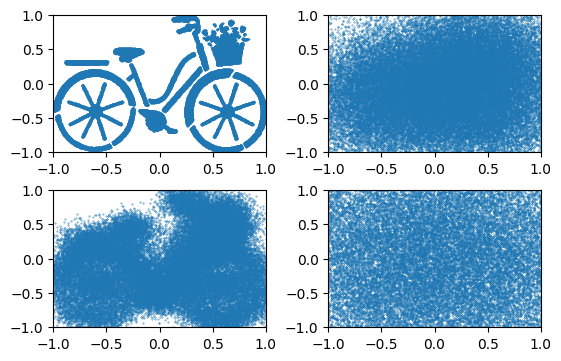

In [9]:
N = len(bicycle)
T = [0, 100, 200, 999]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(5.5, 3.5),
                    layout="constrained")
for row in range(2):
    for col in range(2):
        t = T[row+col*2]
        V = diffusion.q_sample(bicycle, torch.full((N,), t))
        scatter(V, f't={t}', axs[row, col])

## DDPM

In [10]:
class ConditionalDenseLayer(nn.Module):
    def __init__(self, T=1000, isRelu=True):
        super().__init__()
        self.position_enc = self.gen_pe(T, 50, 10000).to(device)
        self.isRelu = isRelu
        
        self.linear1 = nn.Linear(128, 128)
        self.linear2 = nn.Linear(50, 128)
        self.linear3 = nn.Linear(128, 128)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
    
    def forward(self, vector_input, time_input):
        x = self.linear1(vector_input)
        t = self.learnable_sinusoidal_embedding(time_input)
        res = torch.add(x, t)
        if self.isRelu:
            res = self.relu1(res)
        return res
    
    def learnable_sinusoidal_embedding(self, time_input):
        x = self.position_enc[time_input]
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

    def gen_pe(self, max_length, d_model, n):

        # generate an empty matrix for the positional encodings (pe)
        pe = torch.zeros(max_length*d_model).reshape(max_length, d_model) 

        # for each position
        for k in torch.arange(max_length):

            # for each dimension
            for i in torch.arange(d_model//2):

                # calculate the internal value for sin and cos
                theta = k / (n ** ((2*i)/d_model))       

                # even dims: sin   
                pe[k, 2*i] = torch.sin(theta) 

                # odd dims: cos               
                pe[k, 2*i+1] = torch.cos(theta)

        return pe

# Input shape: [N, 3, 32, 32]
class PredictiveModel(nn.Module):
    def __init__(self, T=1000):
        super().__init__()
        self.linear1 = nn.Linear(2, 128)
        self.linear2 = nn.Linear(128, 2)
        self.cdl1 = ConditionalDenseLayer(T)
        self.cdl2 = ConditionalDenseLayer(T)
        self.cdl3 = ConditionalDenseLayer(T)
        self.cdl4 = ConditionalDenseLayer(T, isRelu=False)
    
    def forward(self, vector_input, time_input):
        x0 = self.linear1(vector_input)

        x0 = self.cdl1(x0, time_input)

        x0 = self.cdl2(x0, time_input)

        x0 = self.cdl3(x0, time_input)

        x0 = self.cdl4(x0, time_input)
        x0 = self.linear2(x0)
        return x0

## Training

  0%|          | 0/1000 [00:00<?, ?it/s]

Finished 0 epoch with loss 0.248940
Finished 100 epoch with loss 0.165272
Finished 200 epoch with loss 0.165930
Finished 300 epoch with loss 0.166342
Finished 400 epoch with loss 0.162874
Finished 500 epoch with loss 0.163239
Finished 600 epoch with loss 0.163717
Finished 700 epoch with loss 0.161602
Finished 800 epoch with loss 0.161182
Finished 900 epoch with loss 0.164204


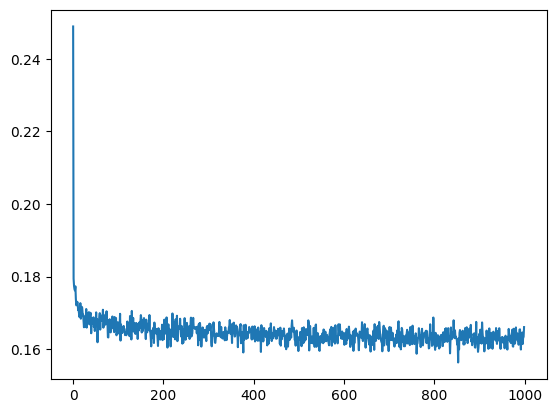

In [11]:
LR = 0.0001
EPOCHS = 1000

run = wandb.init(
    project="DDPM",
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
    },
)

def train(model, optimizer, criterion, data, epochs=EPOCHS, T=1000):
    loss_history = []
    
    torch.set_grad_enabled(True)
    model.train()
    
    for epoch in trange(epochs):
        
        total_loss = 0
        
        for batch in data:
            optimizer.zero_grad()
            
            N = len(batch)

            points = batch.to(device)
            t = torch.randint(low=0, high=T, size=(N,)).to(device)
            noise = torch.randn((N, 2)).to(device)

            x1 = diffusion.q_sample2(points, t, noise)
            
            pred_noise = model(x1, t)

            loss = criterion(pred_noise, noise)
            loss.backward()

            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(data)
        
        wandb.log({"avg_loss": avg_loss})
        
        if epoch % 100 == 0 or epoch === epochs - 1:
            print(f'Finished {epoch} epoch with loss {avg_loss:2f}')
            torch.save(model.state_dict(), f'model_snapshot_{epoch}.pt')
        loss_history.append(avg_loss)
    
    plt.plot(loss_history)

model = PredictiveModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

dataset = CustomDataset(BICYCLE_PATH)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

train(model, optimizer, criterion, dataloader)

## Sampling

In [11]:
@torch.no_grad()
def sample(model, N=5000, T=1000, animate=False):
    x = torch.normal(mean=torch.zeros((N, 2)), std=torch.ones((N, 2)))
    x = x.to(device) 
    
    animated = [x.cpu().detach().numpy()]

    for t in trange(999, -1, -1):
        alpha_t = diffusion.alphas[t]
        alpha_t_ = diffusion.alphas_[t]
        sigma_t = torch.sqrt(diffusion.betas[t]).to(device)
        z = torch.normal(mean=torch.zeros((N, 2)), std=torch.ones((N, 2))).to(device)
        if t == 0:
            z = torch.zeros_like(z).to(device)
        
        temp = x - ((1 - alpha_t) / torch.sqrt(1 - alpha_t_)) * model(x, t)
        x = (1 / torch.sqrt(alpha_t)) * temp + sigma_t * z
        
        if animate:
            animated.append(x.cpu().detach().numpy())
    
    x = x.cpu().detach().numpy()
    return x, animated

In [12]:
def sample_and_print(loaded_model):
    result, animated = sample(loaded_model)
    scatter(result)
    return result, animated
    
def load_model(model_path):
    loaded_model = PredictiveModel()
    loaded_model.load_state_dict(torch.load(model_path))
    loaded_model.eval()
    return loaded_model.to(device)

def load_model_and_sample(model_path):
    sample_and_print(load_model(model_path).to(device))

## Results
**Animation**

In [13]:
loaded_model = load_model('model_snapshot_1000.pt')
_, animated = sample(loaded_model, animate=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


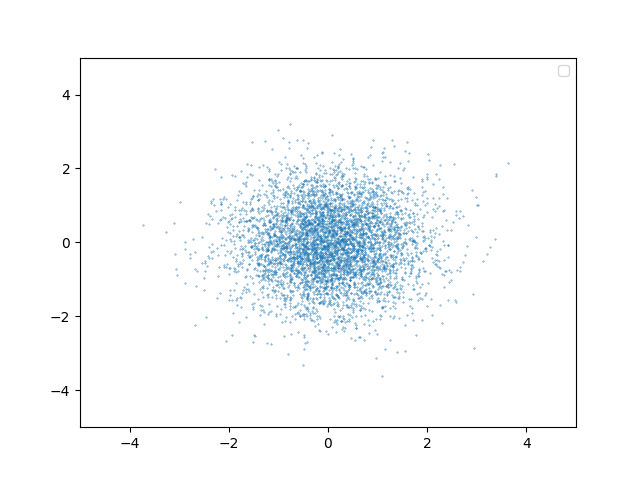

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [22]:
%matplotlib notebook


def animate(animated, skip_frames=5):
    fig, ax = plt.subplots()
    
    scat = ax.scatter(animated[0][:, 0], animated[0][:, 0], s=0.1)
    ax.set(xlim=[-5, 5], ylim=[-5, 5])
    ax.legend()

    def update(frame):
        x = animated[frame][:, 0]
        y = animated[frame][:, 1]
        data = np.stack([x, y]).T
        scat.set_offsets(data)
        return (scat)

    anim = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=25, repeat=True, repeat_delay=1000)
    plt.show()

    writergif = animation.PillowWriter(fps=24) 
    anim.save('denoising.gif', writer=writergif)
    
animate(animated)

**Model after 100 epochs**

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


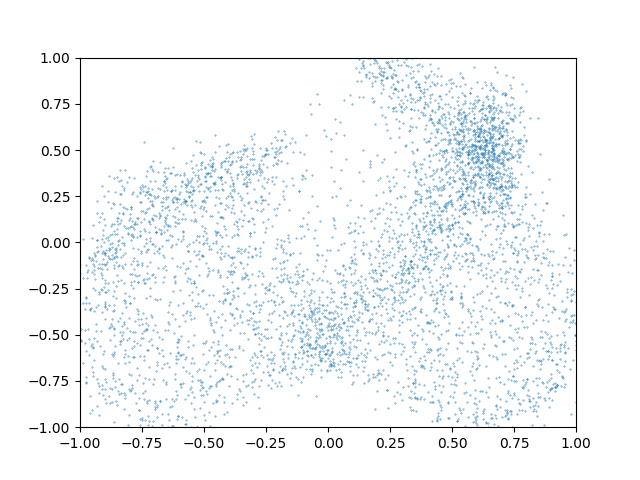

In [34]:
load_model_and_sample('model_snapshot_100.pt')

**Model after 200 epochs**

  0%|          | 0/1000 [00:00<?, ?it/s]

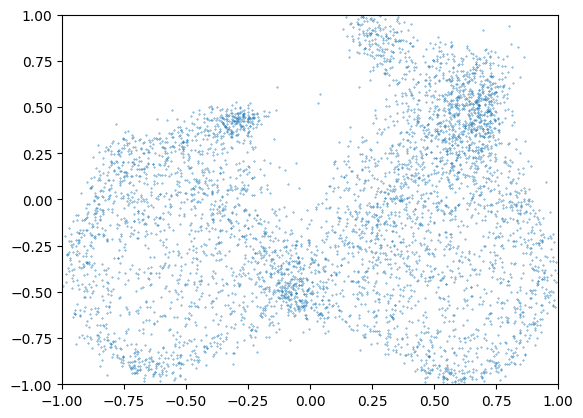

In [17]:
load_model_and_sample('model_snapshot_200.pt')

**Model after 500 epochs**

  0%|          | 0/1000 [00:00<?, ?it/s]

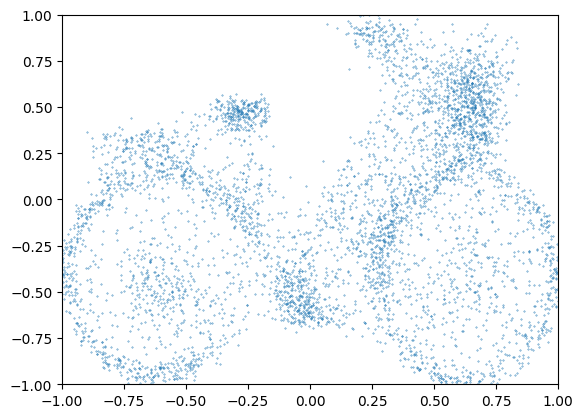

In [18]:
load_model_and_sample('model_snapshot_500.pt')

**Model after 1000 epochs**

  0%|          | 0/1000 [00:00<?, ?it/s]

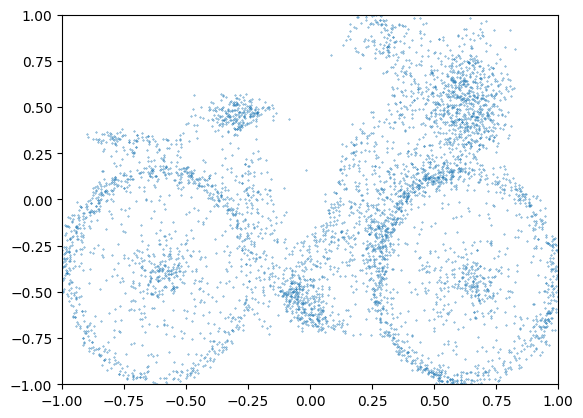

In [19]:
load_model_and_sample('model_snapshot_1000.pt')

## Conclusion
- the quality of the sampling is not proportional to the loss decrease,
- generating new images takes much more time than in the GAN.